# Requirements + setup

In [1]:
# ! pip install sqlalchemy

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.ops import unary_union
import folium
from shapely.geometry import mapping
import json
from pyspark.sql import SparkSession
import unidecode

from matplotlib import pyplot as plt 
import seaborn as sns
from addressing.utils import libpostal
from fuzzywuzzy import fuzz
import nltk
from nltk.corpus import stopwords
from addressing.automatic_matching import automatic_matching
from addressing.automatic_matching.rooftop.rooftop import haversine_distance
import re
import sys, os
import sqlalchemy
from datetime import date


data_path = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/data/Texas"
state = "Texas"
county = 'bexar'
delta = True


print("Delta :",delta)

Updated_geometries_pickle = os.path.join(data_path,'new_APT_2023_03_001_nam_usa_utx_bfp.pkl')
if os.path.isfile(Updated_geometries_pickle):
    print(Updated_geometries_pickle) 

/home/tandon/anaconda3/envs/pygeo/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/tandon/anaconda3/envs/pygeo/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Delta : True
/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/data/Texas/new_APT_2023_03_001_nam_usa_utx_bfp.pkl


In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/tandon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
DB = {
'host' : "10.137.173.84",
'port' : '5432',
'database' :  "STAN",
'user' : "strategicadmin",
'password' :  "TBmG4Yj3DdwOI+Aq"
}

class ReadAndWrite2PostgresDB:

    def __init__(self, engine):
        self.engine = engine

    def read_from_db(self, query, retry_num=3):

        for _ in range(retry_num):
            df = None
            try:
                df = pd.read_sql(query, self.engine)
                return df

            except Exception as e:
                print(e)

        return df

    def write_to_db(self, df, schema, table_name, retry_num=3):

        for _ in range(retry_num):
            try:
                
                df.to_sql(
                    table_name,
                    con=self.engine,
                    if_exists='append',
                    schema=schema,
                    index = False)
                print("Table stored!")
                return 1

            except Exception as e:
                print(e)

        return 0

In [5]:
engine = sqlalchemy.create_engine(f'postgresql+psycopg2://{DB["user"]}:{DB["password"]}@{DB["host"]}:{DB["port"]}/{DB["database"]}',echo = False)
raw2p = ReadAndWrite2PostgresDB(engine)                                

counties = 'cook', 'bexar', 'dallas', 'orange', 'maricopa', 'marion', 'tarrant', 'clark'

In [6]:
date = date.today()
print(date)
print(county)

2023-03-02
bexar


Stopwords

In [7]:
countries_stopwords = {
  'br': stopwords.words('portuguese') + ['rua', 'avenida'], 
  'ca': stopwords.words('french') + stopwords.words('english') +  ['road', 'street', 'st.', 'st', 'rue', 'chemin', 'avenue'],
  'es': stopwords.words('spanish') + ['calle', 'avenida', 'callejón', 'paseo'],
  'fr': stopwords.words('french') + ['rue', 'chemin', 'avenue'],
  'gb': stopwords.words('english') + ['street', 'road', 'avenue', 'st.', 'st', 'drive'],
  'it': stopwords.words('italian') + ['via', 'viale', 'strada'],
  'mx': stopwords.words('spanish') + ['calle', 'avenida', 'callejón', 'paseo'],
  'us': stopwords.words('english') + ['street', 'road', 'avenue', 'st.', 'st', 'drive'],
  'be': stopwords.words('french') + ['rue', 'chemin', 'avenue'],
  'za': stopwords.words('english') + ['street', 'road', 'avenue', 'st.', 'st', 'drive']
}

countries_stopwords = {k:'|'.join(['\\b' + word + '\\b' for word in v]) for k, v in countries_stopwords.items()}

## Reading the data

### Sample addresses

In [8]:
sample_query = f"""SELECT * FROM "STAN_169".sample where county = '{county}'"""
sample_df = raw2p.read_from_db(query = sample_query)
sample_geom = gpd.GeoSeries.from_wkt(sample_df.geometry)
sample_gdf = gpd.GeoDataFrame(sample_df.drop('geometry', axis = 1),
                                geometry = sample_geom,
                                crs = 'EPSG:4326')

In [9]:
print(sample_gdf.shape)
sample_gdf.head()

(1029, 29)


,country,searched_query_unidecode_sample,libpostal_query,libpostal_response,libpostal_house,libpostal_category,libpostal_near,libpostal_house_number,libpostal_road,libpostal_unit,...,libpostal_state_district,libpostal_state,libpostal_country_region,libpostal_country,libpostal_world_region,lat_sample,lon_sample,county,sample_id,geometry
0,USA,"4426 N Hein Rd, San Antonio, TX 78220, USA","{""query"": ""4426 N Hein Rd, San Antonio, TX 782...","{'country': 'usa', 'city': 'san antonio', 'roa...",,,,4426,n hein rd,,...,,tx,,usa,,29.412026,-98.406943,bexar,6232ext2,"POLYGON ((-98.39796 29.41203, -98.39800 29.411..."
1,USA,"21630 Milsa Dr, San Antonio, TX 78256, USA","{""query"": ""21630 Milsa Dr, San Antonio, TX 782...","{'country': 'usa', 'city': 'san antonio', 'roa...",,,,21630,milsa dr,,...,,tx,,usa,,29.642222,-98.622913,bexar,6233ext2,"POLYGON ((-98.61393 29.64222, -98.61397 29.641..."
2,USA,"8227 Wayside Creek, San Antonio, TX 78255, USA","{""query"": ""8227 Wayside Creek, San Antonio, TX...","{'country': 'usa', 'city': 'san antonio', 'roa...",,,,8227,wayside creek,,...,,tx,,usa,,29.671692,-98.646167,bexar,6234ext2,"POLYGON ((-98.63718 29.67169, -98.63723 29.670..."
3,USA,"130A Interloop Rd, San Antonio, TX 78216, USA","{""query"": ""130A Interloop Rd, San Antonio, TX ...","{'country': 'usa', 'city': 'san antonio', 'roa...",,,,130a,interloop rd,,...,,tx,,usa,,29.493616,-98.502956,bexar,6235ext2,"POLYGON ((-98.49397 29.49362, -98.49402 29.492..."
4,USA,"612 Devine St, San Antonio, TX 78210, USA","{""query"": ""612 Devine St, San Antonio, TX 7821...","{'country': 'usa', 'city': 'san antonio', 'roa...",,,,612,devine st,,...,,tx,,usa,,29.408747,-98.480484,bexar,6236ext2,"POLYGON ((-98.47150 29.40875, -98.47154 29.407..."


### Source

In [10]:
source_query = f"""SELECT * FROM "STAN_169".source_v0 where county = '{county}'"""
source_df = raw2p.read_from_db(query = source_query)
source_geom = gpd.GeoSeries.from_wkt(source_df.geometry)
source_gdf = gpd.GeoDataFrame(source_df.drop('geometry', axis = 1),
                                geometry = source_geom,
                                crs = 'EPSG:4326')

In [11]:
source_gdf.head()

,feat_id,postal_code,hsn,state,city,street_name,country_code,prefix,suffix,pre_dir,post_dir,x,y,county,geometry
0,00005554-3400-2800-0000-000000b7a84b,78245,2922,TX,San Antonio,Amber Glade,USA,None,None,None,None,-98.678005,29.401356,bexar,POINT (-98.67800 29.40136)
1,ebf20abd-d425-4b88-a049-4acd9df6ca5e,78227,174,TX,San Antonio,Ray Ellison,USA,None,None,None,None,-98.643672,29.368750,bexar,POINT (-98.64367 29.36875)
2,00005554-3400-2800-0000-000000b883a4,78250,7447,TX,San Antonio,Branston,USA,None,None,None,None,-98.690044,29.511031,bexar,POINT (-98.69004 29.51103)
3,00005554-3400-2800-0000-000000baaf03,78223,311,TX,San Antonio,Kate Schenck Ave,USA,None,Ave,None,None,-98.430875,29.361513,bexar,POINT (-98.43088 29.36151)
4,00005554-3400-2800-0000-000000ba28b3,78212,1706,TX,San Antonio,McCullough Ave,USA,None,Ave,None,None,-98.491592,29.445320,bexar,POINT (-98.49159 29.44532)


In [12]:
# gdf = gpd.GeoDataFrame(source_gdf[['feat_id','x','y','county','geometry']], crs="epsg:4326", geometry='geometry')
# gdf.to_crs("epsg:4326")
# gdf.to_file(os.path.join(data_path,state,county,'Apt_realignment_MSFT_OSM/source_df.shp'), driver='ESRI Shapefile')

In [13]:
# source_df = pd.read_pickle(f'wrang_source_v0_{county}.pickle')
# source_gdf = gpd.GeoDataFrame(source_df, geometry = 'geometry', crs='EPSG:4326')

### Ingesting Deltas

Here goes the table of new changes to make to coordinates:

In [14]:
print("DELTA for updating geometries is ",delta)
if delta:
    delta_table_read = pd.read_pickle(Updated_geometries_pickle)
    delta_table_read = delta_table_read[['feat_id', 'updated_APT_with_BFP']]
    delta_table_read['datetime_version'] = pd.Timestamp.now(tz = 'utc')


DELTA for updating geometries is  True


In [15]:
if delta:
    delta_table_read.rename(columns = {'updated_APT_with_BFP':'updated_geometries'}, inplace = True)
    print(delta_table_read.shape)
    delta_table_read.head()

(7656412, 3)


In [16]:
delta_table_read.rename(columns = {'updated_APT_with_BFP':'updated_geometries'}, inplace = True)

In [17]:
if delta:
    delta_table_write = delta_table_read[['feat_id', 'updated_geometries', 'datetime_version']]
    delta_table_write['updated_geometries'] = delta_table_write['updated_geometries'].astype(str)

In [18]:
if delta:
    raw2p.write_to_db(df = delta_table_write, schema = 'STAN_169', table_name = 'delta_table')

Table stored!


### Reading Deltas

In [19]:
if delta:  
  delta_query = f"""
  SELECT * FROM "STAN_169".delta_table where county = '{county}'
  """
  delta_df = raw2p.read_from_db(query = delta_query)
  delta_geom = gpd.GeoSeries.from_wkt(delta_df.updated_geometries)
  delta_gdf = gpd.GeoDataFrame(delta_df.drop('updated_geometries', axis = 1),geometry = delta_geom,crs = 'EPSG:4326')
  delta_gdf.head()

In [20]:
if delta:
  delta_gdf.head()

### Replacing Delta Changes

In [21]:
def replace_geometries(source_gdf, delta_gdf):
    '''
    Takes a 'source' geodataframe - copy of MNR database, a 'delta' geodataframe and replaces, for every APT (key: feat_id) in source dataframe, the 
    coordinates in the sorce with the coordinates in the new 

            Parameters:
                    source_gdf (gpd.GeoDataFrame): geodataframe containing MNR coordinates for every APT (feat_id)
                    delta_gdf (gpd.GeoDataFrame): geodataframe containing NEW coordinates for some APTs (feat_id)

            Returns:
                    source_gdf_new (gpd.GeoDataFrame): geodataframe containing MNR information for APT but with new coordinates
    '''
    delta_gdf_grouped = delta_gdf[delta_gdf.groupby('feat_id').datetime_version.transform('max') == delta_gdf.datetime_version]

    source_gdf_new = source_gdf.merge(delta_gdf_grouped[["feat_id", "geometry"]], on="feat_id", how="left")

    source_gdf_new.loc[~source_gdf_new.geometry_y.isna(), "geometry_x"] = source_gdf_new.loc[~source_gdf_new.geometry_y.isna(), "geometry_y"]

    source_gdf_new = source_gdf_new.drop(["geometry_y"], axis=1).rename({"geometry_x": "geometry"}, axis = 1)

    source_gdf_new = gpd.GeoDataFrame(source_gdf_new.drop('geometry', axis = 1), 
                                    geometry = source_gdf_new.geometry, crs = 'EPSG:4326')

    return source_gdf_new

In [22]:
if delta:
    source_delta = replace_geometries(source_gdf, delta_gdf)
    source_delta_gdf = gpd.GeoDataFrame(source_delta.drop('geometry', axis = 1), geometry = source_delta.geometry, crs = 'EPSG:4326')
    source_delta_gdf.x = source_delta_gdf.geometry.apply(lambda p: p.x)
    source_delta_gdf.y = source_delta_gdf.geometry.apply(lambda p: p.y)

### Joining Sample and Source - Spatial Join

In [23]:
if delta:
  joined_sample = source_delta_gdf.sjoin(sample_gdf, how='right', predicate='intersects')
else:
  joined_sample = source_gdf.sjoin(sample_gdf, how = 'right', predicate = 'intersects')

In [24]:
joined_sample.head()

,index_left,feat_id,postal_code,hsn,state,city,street_name,country_code,prefix,suffix,...,libpostal_state_district,libpostal_state,libpostal_country_region,libpostal_country,libpostal_world_region,lat_sample,lon_sample,county_right,sample_id,geometry
0,660,00005554-3400-2800-0000-000000bb2762,78220,4251,TX,San Antonio,Algruth Dr,USA,None,Dr,...,,tx,,usa,,29.412026,-98.406943,bexar,6232ext2,"POLYGON ((-98.39796 29.41203, -98.39800 29.411..."
0,1110,00005554-3400-2800-0000-000000bb27e9,78220,4315,TX,San Antonio,Jarbet Dr,USA,None,Dr,...,,tx,,usa,,29.412026,-98.406943,bexar,6232ext2,"POLYGON ((-98.39796 29.41203, -98.39800 29.411..."
0,1497,00005554-3400-2800-0000-000000bb2101,78220,825,TX,San Antonio,Holmgreen Rd,USA,None,Rd,...,,tx,,usa,,29.412026,-98.406943,bexar,6232ext2,"POLYGON ((-98.39796 29.41203, -98.39800 29.411..."
0,2655,00005554-3400-2800-0000-000000bb2707,78220,4231,TX,San Antonio,Jarbet Dr,USA,None,Dr,...,,tx,,usa,,29.412026,-98.406943,bexar,6232ext2,"POLYGON ((-98.39796 29.41203, -98.39800 29.411..."
0,2678,00005554-3400-2800-0000-000000bb27a1,78220,4326,TX,San Antonio,Jarbet Dr,USA,None,Dr,...,,tx,,usa,,29.412026,-98.406943,bexar,6232ext2,"POLYGON ((-98.39796 29.41203, -98.39800 29.411..."


In [25]:
# if delta: 
#   del source_gdf
#   del delta_gdf
# else:
#   del source_delta_gdf

In [26]:
joined_sample.rename({
    'hsn': 'hsnum',
    'street_name': 'st_name',
    'postal_code': 'zip_code'
},
axis = 1, 
inplace = True)

# Parsing Joined Sample

In [27]:
def parse_joined_sample(spatial_joined_df: pd.DataFrame) -> pd.DataFrame:
    '''Function inversely parses the addresses to create a searched query format so that the addresses in the source 
    can be compared to the addresses in the sample.

    :param spatial_joined_df: DataFrame that contains the addresses from the source that are within the polygon of 
    the sample generated. It must contain the columns: ['hsn', 'unit_type', 'unit_num', 'pre_dir', 'prefix', 'suffix'
    'post_dir', 'city', 'state', 'zip_code']
    :type spatial_joined_df: pd.DataFrame
    :return: The same dataframe with a column that contains the full addresses inversely parsed.
    :rtype: pd.DataFrame
    '''

    df = spatial_joined_df.copy()

    dict_of_columns = {
        'hsnum': ' ', 'pre_dir': ' ', 'st_name': ' ', 'suffix': ', ', 'city': ' ', 'state': ' ', 'zip_code': ', ', 'country': ''
    }
    df['pre_dir'].fillna('', inplace=True)
    df['prefix'].fillna('', inplace=True)
    df['suffix'].fillna('', inplace=True)
    df['post_dir'].fillna('', inplace=True)

    for column in dict_of_columns.keys():

        df[column + '_modified'] = df[column].astype(str) + dict_of_columns[column]

    list_of_modified_columns = [col for col in df.columns if '_modified' in col]

    df['searched_query'] = df[list_of_modified_columns].sum(axis=1)

    df['street_name'] = df['pre_dir'] + ' ' + df['prefix'] + ' ' + df['st_name'] + ' ' + df['suffix'] + ' ' + df['post_dir']
    df['name'] = '' #df['state']

    df = df.rename(columns={'hsnum': 'hsn', 'searched_query': 'address', 'zip_code': 'postal_code', 'city': 'place_name', 'y': 'lat', 'x': 'lon'})
    return df

In [28]:
parsed_df = parse_joined_sample(joined_sample)
parsed_df.head()

,index_left,feat_id,postal_code,hsn,state,place_name,st_name,country_code,prefix,suffix,...,pre_dir_modified,st_name_modified,suffix_modified,city_modified,state_modified,zip_code_modified,country_modified,address,street_name,name
0,660,00005554-3400-2800-0000-000000bb2762,78220,4251,TX,San Antonio,Algruth Dr,USA,,Dr,...,,Algruth Dr,"Dr,",San Antonio,TX,"78220,",USA,"4251 Algruth Dr Dr, San Antonio TX 78220, USA",Algruth Dr Dr,
0,1110,00005554-3400-2800-0000-000000bb27e9,78220,4315,TX,San Antonio,Jarbet Dr,USA,,Dr,...,,Jarbet Dr,"Dr,",San Antonio,TX,"78220,",USA,"4315 Jarbet Dr Dr, San Antonio TX 78220, USA",Jarbet Dr Dr,
0,1497,00005554-3400-2800-0000-000000bb2101,78220,825,TX,San Antonio,Holmgreen Rd,USA,,Rd,...,,Holmgreen Rd,"Rd,",San Antonio,TX,"78220,",USA,"825 Holmgreen Rd Rd, San Antonio TX 78220, USA",Holmgreen Rd Rd,
0,2655,00005554-3400-2800-0000-000000bb2707,78220,4231,TX,San Antonio,Jarbet Dr,USA,,Dr,...,,Jarbet Dr,"Dr,",San Antonio,TX,"78220,",USA,"4231 Jarbet Dr Dr, San Antonio TX 78220, USA",Jarbet Dr Dr,
0,2678,00005554-3400-2800-0000-000000bb27a1,78220,4326,TX,San Antonio,Jarbet Dr,USA,,Dr,...,,Jarbet Dr,"Dr,",San Antonio,TX,"78220,",USA,"4326 Jarbet Dr Dr, San Antonio TX 78220, USA",Jarbet Dr Dr,


In [29]:
del joined_sample

# Matching Adresses

In [30]:
def apt_similarity_filter(
    #country:str,
    df:pd.DataFrame,
    sample_df:pd.DataFrame,
    stopwords_pattern: str = '') -> pd.DataFrame:
    """Performs matching after making call in a given radius

    :param country: country to call in MNR
    :type country: str
    :param df: DataFrame containing the sample addresses (must have coordinates)
    :type df: pd.DataFrame
    :param sample_df: DataFrame containing libpostal components for sample (df) addresses
    :type sample_df: pd.DataFrame
    :param radius: radius of the buffer
    :type radius: float
    :param inner_radius: radius in meters of a smaller buffer. When bigger than zero, we are essentially getting the point in a disk, defaults to 0
    :type inner_radius: int or float, optional
    :param stopwords_pattern: regex pattern to remove stopwords, if needed. Optional, defaults to None
    :type stopwords_pattern: str
    :return: DataFrame with the APTs that matched
    :rtype: pd.DataFrame
    """
    apts_df = df.copy()

    # Fill NAs
    apts_df[['address', 'street_name', 'hsn', 'postal_code',
                    'place_name', 'name']] = apts_df[['address', 'street_name', 'hsn',
                                                                            'postal_code', 'place_name', 'name']].fillna('')

    # Drop duplicates
    #apts_df = apts_df.drop_duplicates(['searched_query', 'address']).reset_index(drop=True)
    
    
    # Create extra columns for stopwords, optional unidecode 
    cols_stopwords = ['address', 'street_name', 'place_name']
    for col in cols_stopwords:
        col_create = col + '_no_stopwords'
        apts_df[col_create] =  apts_df[col].str.replace(stopwords_pattern, '', case=False, regex=True)
        
    for col in cols_stopwords:
        col_create = col + '_no_stopwords_unidecode'
        apts_df[col_create] =  apts_df[col+'_no_stopwords'].apply(lambda x: unidecode.unidecode(x))
        
    
    # Merge to APTs
    #apts_df = apts_df.merge(sample_df.drop(columns=['country', 'searched_query_unidecode_sample']),
    #                                      how='left', 
    #                                      on=['searched_query'])
    apts_df['libpostal_road_no_stopwords'] = apts_df.libpostal_road.str.replace(stopwords_pattern, '', case=False, regex=True)


    # House number similarity: filter obvious non matches
    apts_df['hsn_similarity'] = list(map(fuzz.token_set_ratio, apts_df.libpostal_house_number, apts_df.hsn))
    apts_df['re_pattern'] = '\\b' + apts_df.hsn.astype(str) + '\\b'
    #apts_df['hsn_in_query'] = apts_df.apply(lambda x: bool(re.search(x.re_pattern, x.searched_query_unidecode_sample)), axis=1)
    #apts_df['hsn_similarity'] = np.where((apts_df.hsn_in_query), 100, apts_df.hsn_similarity)

    dropped_df = apts_df.loc[apts_df.hsn_similarity <= 60].reset_index(drop=True)
    
    
    apts_df = apts_df.loc[apts_df.hsn_similarity > 60].reset_index(drop=True)

    # Postal code similarity
    apts_df['postcode_similarity'] = list(map(fuzz.WRatio, 
                                                     apts_df.libpostal_postcode, 
                                                     apts_df.postal_code.fillna('').astype(str)))
    apts_df['postcode_similarity'] = np.where(apts_df.libpostal_postcode=='', np.nan,
                                                     np.where(apts_df.postal_code=='', 50, apts_df.postcode_similarity))

    
    # Road similarity
    apts_df['road_similarity'] = list(map(fuzz.token_set_ratio, 
                                                 apts_df.libpostal_road_no_stopwords, 
                                                 apts_df.street_name_no_stopwords))
    apts_df['road_similarity_unidecode'] = list(map(fuzz.token_set_ratio, 
                                                           apts_df.libpostal_road_no_stopwords, 
                                                           apts_df.street_name_no_stopwords_unidecode)) 
    apts_df['road_similarity'] = apts_df[['road_similarity', 'road_similarity_unidecode']].max(axis=1)
    
    # Locality similarity
    apts_df['searched_query_tokens'] = (apts_df.libpostal_road.astype(str) + ' ' + 
                                               apts_df.libpostal_house_number.astype(str) + ' ' + 
                                               apts_df.libpostal_postcode.astype(str))
    
    apts_df['provider_tokens'] = (apts_df.street_name.astype(str) + ' ' + 
                                         apts_df.hsn.astype(str) + ' ' + apts_df.postal_code.astype(str))
    apts_df['aux_searched_query'] = apts_df.apply(lambda x: automatic_matching.replace_tokens(x.searched_query_unidecode_sample, x.searched_query_tokens), axis=1)
    apts_df['aux_provider_address'] = apts_df.apply(lambda x: automatic_matching.replace_tokens(x.address, x.provider_tokens), axis=1)
    apts_df['aux_provider_address'] = apts_df.aux_provider_address.fillna('').apply(lambda x: unidecode.unidecode(x))
    apts_df['locality_wratio'] = apts_df.apply(lambda x: fuzz.WRatio(str(x.aux_searched_query).lower(), str(x.aux_provider_address).lower()), axis=1)
    apts_df['locality_city_state_ratio'] = apts_df.apply(lambda x: fuzz.WRatio(str(x.libpostal_city) + ' ' + str(x.libpostal_state),
                                                                                            str(x.place_name) + ' ' + str(x.name)), axis=1)
    apts_df['locality_similarity'] = apts_df[['locality_wratio', 'locality_city_state_ratio']].mean(axis=1)

    apts_df['mnr_query_distance'] = apts_df.apply(lambda x: haversine_distance(x.lat, x.lon,
                                                                                               x.lat_sample, x.lon_sample)
                                                                  if not np.isnan(x.lat) else 1e7
                                                                  , axis=1)

    # Compute mean similarity
    apts_df['mean_similarity'] = (apts_df[['locality_similarity', 'hsn_similarity', 
                                                         'postcode_similarity', 'road_similarity']].mean(axis=1)
                                        * np.where(apts_df.hsn_similarity >= 70 , 1, 0)
                                        * np.where(apts_df.road_similarity >= 60 , 1, 0)  
                                        * np.where(apts_df.mnr_query_distance > 1000, 0, 1)
                                        )


    apts_df_matching = (
        apts_df.sort_values(by='mnr_query_distance')
        .loc[apts_df.groupby(['sample_id'])
        .mean_similarity.idxmax()]
        .reset_index(drop=True)
    )


    # Compute matching
    apts_df_matching['match'] = pd.NaT
    
    apts_df_matching['match'] = np.where(apts_df_matching.mean_similarity >= 70, 1, pd.NaT) #90 so far best

    #address_matches = apts_df_matching['searched_query_unidecode_sample']
    address_sample_ids = apts_df_matching['sample_id']
    
    #non_matches = dropped_df[~dropped_df['searched_query_unidecode_sample'].isin(address_matches)]
    non_matches_ids = dropped_df[~dropped_df['sample_id'].isin(address_sample_ids)]
    
    #addresses_to_add = non_matches['searched_query_unidecode_sample'].unique()
    addresses_to_add_ids = non_matches_ids['sample_id'].unique()
     
    addresses_id_df = pd.DataFrame(
        {'sample_id': addresses_to_add_ids, 'match': [pd.NaT] * len(addresses_to_add_ids)}
    )
    
    addresses_id_df = addresses_id_df.merge(sample_df[['sample_id', 'searched_query_unidecode_sample']], on = 'sample_id', how = 'left')
    
    cols_to_add = [col for col in apts_df_matching if col not in addresses_id_df.columns]
    
    addresses_id_df.loc[:, cols_to_add] = ''
    addresses_id_df_reordered = addresses_id_df[apts_df_matching.columns]
    
    apts_final = pd.concat([apts_df_matching, addresses_id_df_reordered])
    

    return apts_final

In [31]:
similarity_df = apt_similarity_filter(df = parsed_df, sample_df = sample_gdf, stopwords_pattern = countries_stopwords.get('us'))
del sample_gdf
del parsed_df

In [32]:
similarity_df['match'] = similarity_df['match'].fillna(0)

match_proportion = np.mean(similarity_df['match'])
clean_proportion = round(match_proportion * 100, 2)
print(f'The proportion of matches is: {clean_proportion}%')

The proportion of matches is: 96.6%


In [33]:
print(similarity_df.shape)
similarity_df.head()

(1029, 77)


,index_left,feat_id,postal_code,hsn,state,place_name,st_name,country_code,prefix,suffix,...,searched_query_tokens,provider_tokens,aux_searched_query,aux_provider_address,locality_wratio,locality_city_state_ratio,locality_similarity,mnr_query_distance,mean_similarity,match
0,330135,00005554-3400-2800-0000-000000bb2792,78220,4426,TX,San Antonio,N Hein Rd,USA,,Rd,...,n hein rd 4426 78220,N N Hein Rd Rd 4426 78220,hei sa atoio tx usa,hei sa atoio tx usa,100,86,93.0,0.0,98.25,1
1,33226,00005554-3400-2800-0000-000000cdcb6a,78256,21330,TX,San Antonio,Milsa St,USA,,St,...,milsa dr 21630 78256,Milsa St St 21330 78256,san antonio tx usa,san antonio tx usa,100,86,93.0,253.6,93.25,1
2,232124,00005554-3400-2800-0000-000000cefa00,78255,8227,TX,San Antonio,Wayside Crk,USA,,Crk,...,wayside creek 8227 78255,Wayside Crk Crk 8227 78255,san antonio tx usa,san antonio tx usa,100,84,92.0,13.8,96.0,1
3,304710,00005554-3400-2800-0000-000000cdbd26,78216,130,TX,San Antonio,Interloop Rd,USA,,Rd,...,interloop rd 130a 78216,Interloop Rd Rd 130 78216,san antonio tx usa,san antonio tx usa,100,84,92.0,0.2,94.5,1
4,106166,00005554-3400-2800-0000-000000b9fc60,78210,612,TX,San Antonio,Devine St,USA,,St,...,devine st 612 78210,Devine St St 612 78210,san antonio tx usa,san antonio tx usa,100,84,92.0,2.5,98.0,1


In [34]:
match_df = similarity_df[['feat_id', 'match', 'sample_id']]
match_df['county'] = county
match_df['datetime_run'] = pd.Timestamp.now(tz = 'utc')
match_df.rename({'match': 'asf'}, axis = 1, inplace = True)

/tmp/ipykernel_8094/2013992509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_df['county'] = county
/tmp/ipykernel_8094/2013992509.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_df['datetime_run'] = pd.Timestamp.now(tz = 'utc')
/tmp/ipykernel_8094/2013992509.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

In [35]:
print("shape of the data",match_df.shape)
match_df.head()

shape of the data (1029, 5)


,feat_id,asf,sample_id,county,datetime_run
0,00005554-3400-2800-0000-000000bb2792,1,6232ext2,bexar,2023-03-02 15:16:34.478958+00:00
1,00005554-3400-2800-0000-000000cdcb6a,1,6233ext2,bexar,2023-03-02 15:16:34.478958+00:00
2,00005554-3400-2800-0000-000000cefa00,1,6234ext2,bexar,2023-03-02 15:16:34.478958+00:00
3,00005554-3400-2800-0000-000000cdbd26,1,6235ext2,bexar,2023-03-02 15:16:34.478958+00:00
4,00005554-3400-2800-0000-000000b9fc60,1,6236ext2,bexar,2023-03-02 15:16:34.478958+00:00


#### Bootstrapping

In [36]:
import numpy as np
import statsmodels.api as sm
import pylab

def bootstrap_resample(df, agg_fun, times=1000, seed=0):
    reboot = []
    
    for t in range(times):
        df_boot = df.sample(frac = 1, replace=True, random_state = t+seed)
        reboot.append(agg_fun(df_boot))
    draw_qqplot(reboot)
    return reboot

def draw_qqplot(reboot):
    data = np.asarray(reboot)
    # sm.ProbPlot(data)
    sm.qqplot(data, line='45')
    pylab.show()


def percentile_bootstrap(df, agg_fun, conf=0.95, times=1000, seed=0):
    """Generic Percentile Bootstrap
    This function returns a percentile bootstrap confidence interval for a statistic.
    Args:
        df (pandas.DataFrame): DataFrame with the observed random vectors. Each row represents an observation an each column is a random variable.
        agg_fun (function): Aggregation function. This function should receive as input a pandas.DataFrame (resamples) and return a 
        number with the computed statistic.
        conf (float, optional): Confidence level of the returned interval. Defaults to 0.9.
        times (int, optional): Bootstrap resamples. Defaults to 1000.
        seed (int, optional): Random seed. Defaults to 0.
    Returns:
        numpy.array: Percentile Boostrap CI [lower, upper]
    """    
    reboot = bootstrap_resample(df, agg_fun, times, seed)
    return np.quantile(reboot, [(1-conf)/2, (1-conf)/2+conf])

##### Plot normalized Similarity data 

Text(0.5, 0.98, 'Data distribution')

<Figure size 720x504 with 0 Axes>

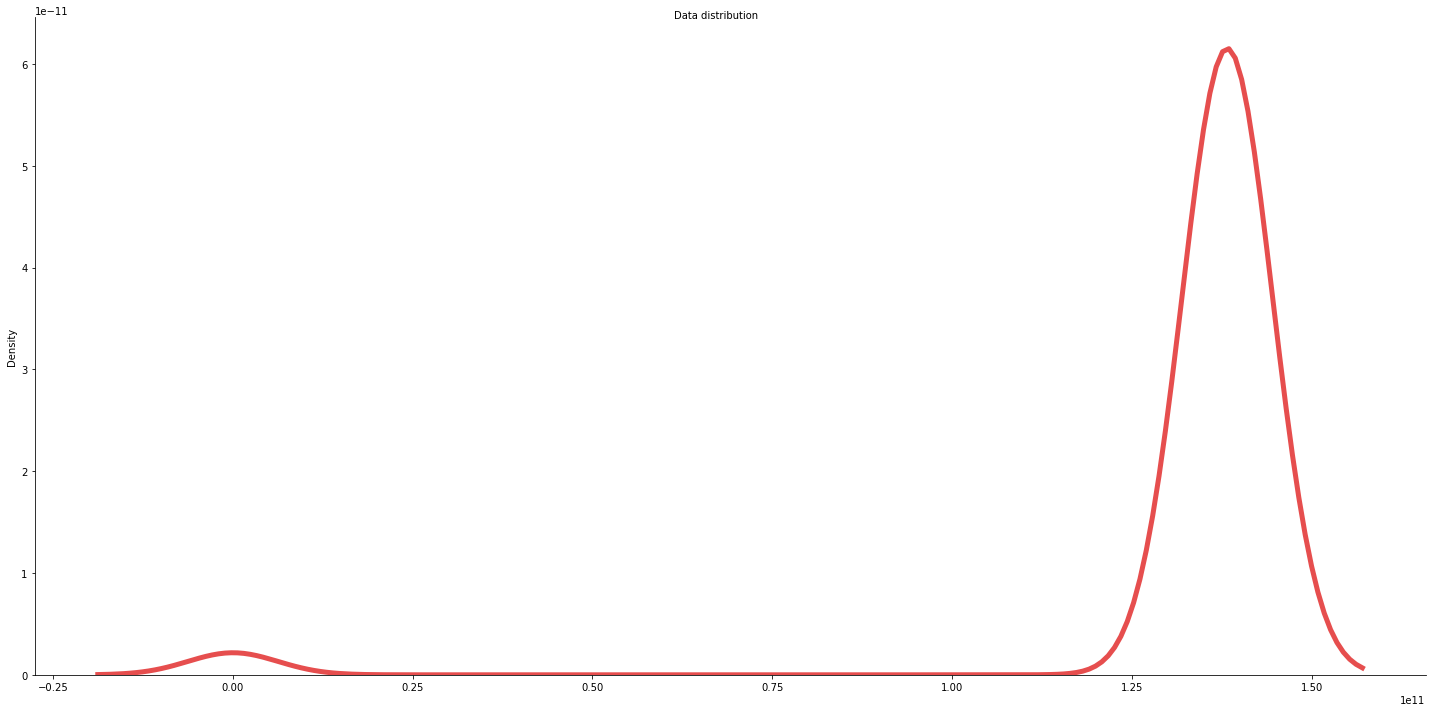

In [37]:
from scipy.stats import yeojohnson

norm_data,_ = yeojohnson(similarity_df['match'])

plt.figure(figsize=(10,7))
ax = sns.displot(norm_data, kind = "kde",color = "#e64e4e", height=10, aspect=2,
            linewidth = 5 )
ax.fig.suptitle('Data distribution', size = 10)

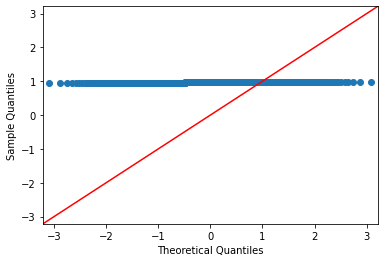

In [38]:
[lower_distance, upper_distance] = percentile_bootstrap(similarity_df['match'], np.mean)

# print(lower_distance,upper_distance)

In [39]:
if delta:
    version = date
else:
    version = 'New_benchmark'

results_sum = pd.DataFrame(
    data=[[lower_distance, match_proportion, upper_distance, '%', 'ASF', version, county]], 
    columns=['lower_bound', 'calculated_metric', 'upper_bound', 'units', 'metric', 'version', 'county'], index = None)
results_sum

,lower_bound,calculated_metric,upper_bound,units,metric,version,county
0,0.954325,0.965986,0.976701,%,ASF,2023-03-02,bexar


## Positional Accuracy

### 90th percentile

We consider the 90th percentile of the distance of matches as a metric for the Positional Accuracy. The distance we obtain below is be the distance for which 90% of the data is lower. The interesting thing about this metric is that it's expressed in terms of distance.

In [40]:
matches_df = similarity_df[similarity_df['match'] == 1]

matches_df['mnr_query_distance'] = matches_df['mnr_query_distance'].astype(float)

del similarity_df

/tmp/ipykernel_8094/1420054033.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches_df['mnr_query_distance'] = matches_df['mnr_query_distance'].astype(float)


##### Plot normalized MNr Query Distance match Data 

Text(0.5, 0.98, 'Data distribution')

<Figure size 720x504 with 0 Axes>

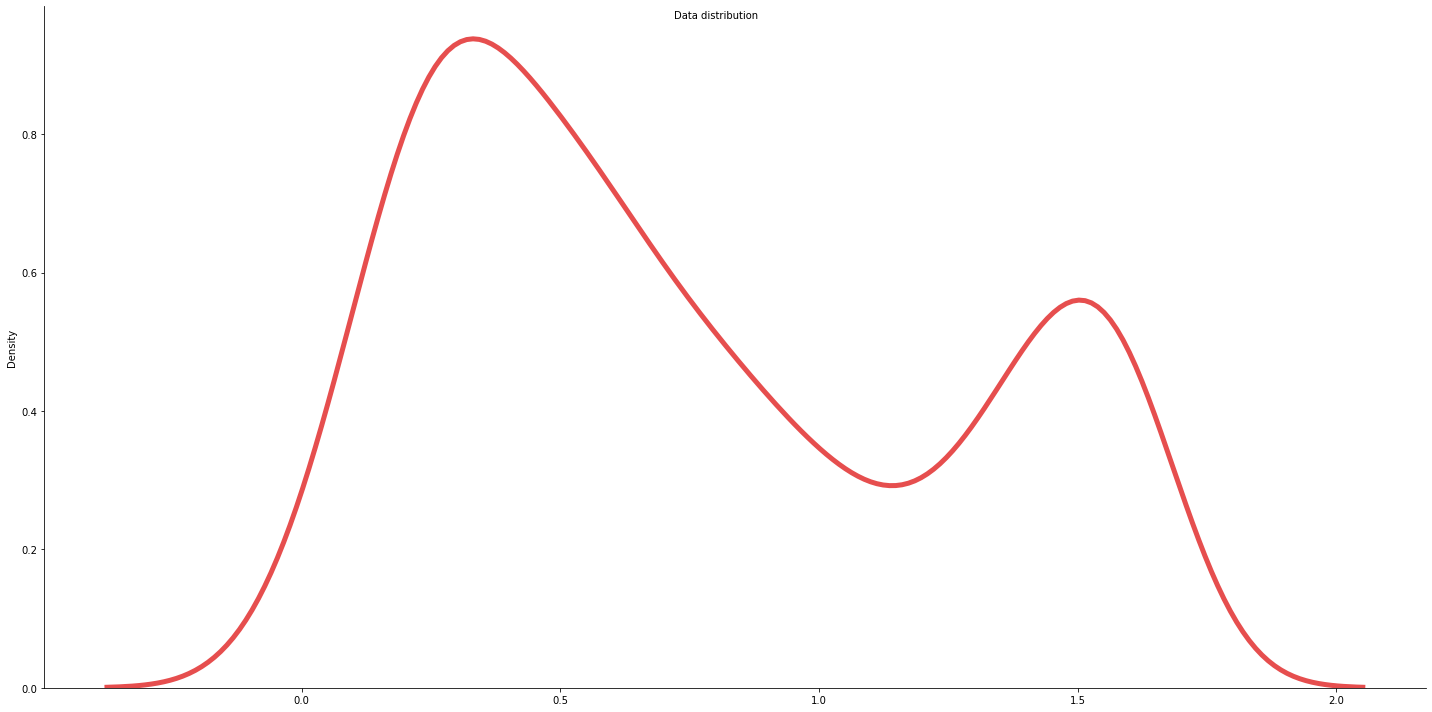

In [41]:
from scipy.stats import yeojohnson

norm_data,_ = yeojohnson(matches_df['mnr_query_distance'])

plt.figure(figsize=(10,7))
ax = sns.displot(norm_data, kind = "kde",color = "#e64e4e", height=10, aspect=2,
            linewidth = 5 )
ax.fig.suptitle('Data distribution', size = 10)

In [42]:
positional_accuracy_distance = round(np.quantile(matches_df['mnr_query_distance'], 0.9), 2)
print(f'Positional Accuracy (90th percentile distance) is: {positional_accuracy_distance}m')

Positional Accuracy (90th percentile distance) is: 48.67m


#### Bootstrapping

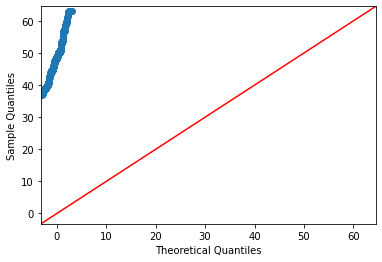

In [43]:
[lower_percentile90, upper_percentile90] = percentile_bootstrap(
    matches_df['mnr_query_distance'], lambda x: np.quantile(x, 0.9))

In [44]:
if delta:
    version = date
else:
    version = 'New_benchmark'

new_result = pd.DataFrame(
    data=[[lower_percentile90, positional_accuracy_distance, upper_percentile90, 'meters', '90p', version, county]], 
    columns=['lower_bound', 'calculated_metric', 'upper_bound', 'units', 'metric', 'version', 'county'], index = None)
results_sum = pd.concat([results_sum, new_result])
results_sum

,lower_bound,calculated_metric,upper_bound,units,metric,version,county
0,0.954325,0.965986,0.976701,%,ASF,2023-03-02,bexar
0,39.830000,48.670000,59.690000,meters,90p,2023-03-02,bexar


### % of matches below 50m

In [45]:
proportion_50m_matches = (matches_df['mnr_query_distance'] <= 50).mean()
nice_num_50m = round(proportion_50m_matches * 100, 1)
print(f'The calculated percentage of matches within 50 meters is {nice_num_50m}%')

The calculated percentage of matches within 50 meters is 90.2%


Text(0.5, 0.98, 'Data distribution')

<Figure size 720x504 with 0 Axes>

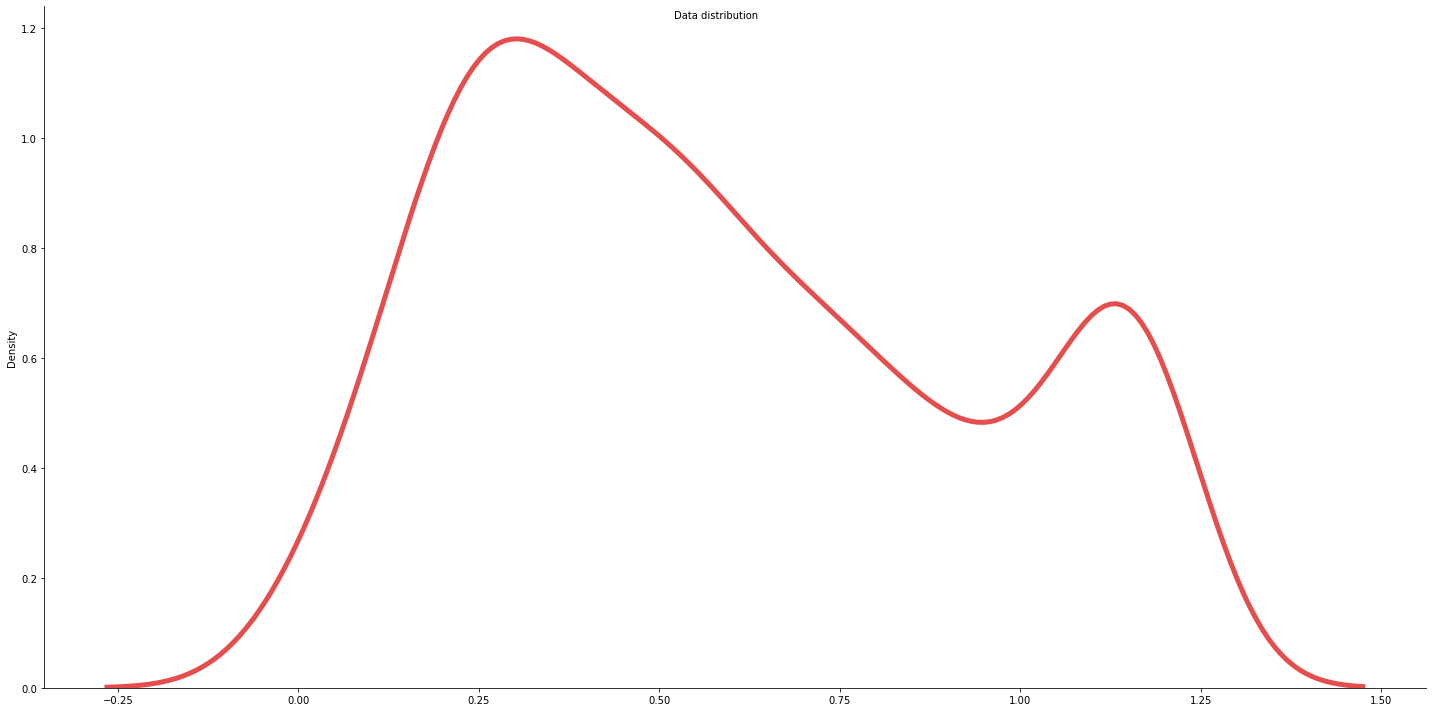

In [46]:

norm_data,_ = yeojohnson(matches_df['mnr_query_distance'].loc[matches_df['mnr_query_distance']<=50])

plt.figure(figsize=(10,7))
ax = sns.displot(norm_data, kind = "kde",color = "#e64e4e", height=10, aspect=2,
            linewidth = 5 )
ax.fig.suptitle('Data distribution', size = 10)

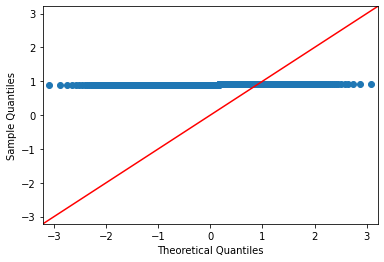

In [47]:
[lower_50m_pa, upper_50m_pa] = percentile_bootstrap(matches_df['mnr_query_distance'] <= 50, np.mean)

In [48]:
if delta:
    version = date
else:
    version = 'New_benchmark'

new_result = pd.DataFrame(
     data=[[lower_50m_pa, proportion_50m_matches, upper_50m_pa, '%', 'APA', version, county]], 
    columns=['lower_bound', 'calculated_metric', 'upper_bound', 'units', 'metric', 'version', 'county'])
results_sum = pd.concat([results_sum, new_result])
results_sum

,lower_bound,calculated_metric,upper_bound,units,metric,version,county
0,0.954325,0.965986,0.976701,%,ASF,2023-03-02,bexar
0,39.830000,48.670000,59.690000,meters,90p,2023-03-02,bexar
0,0.884306,0.902414,0.919517,%,APA,2023-03-02,bexar


In [ ]:
# set(sample_gdf.sample_id) == set(similarity_df.sample_id)

# Join Matches Table

In [ ]:
matches_df[['sample_id', 'mnr_query_distance']]

In [ ]:
match_df = match_df.merge(matches_df[['sample_id', 'mnr_query_distance']], on = ['sample_id'], how = 'left')
match_df['apa'] = match_df.mnr_query_distance.apply(lambda x: 1 if x < 52 else 0)
# match_df.drop('mnr_query_distance', axis = 1, inplace = True)
# raw2p.write_to_db(match_df, table_name = 'matches_table', schema = 'STAN_169')

In [ ]:
if delta:
  match_df = match_df.merge(source_delta_gdf[['feat_id', 'geometry']], on = ['feat_id'], how = 'inner')
  del source_delta_gdf
else:
  match_df = match_df.merge(source_gdf[['feat_id', 'geometry']], on = ['feat_id'], how = 'inner')
  del source_gdf

In [ ]:
match_df.geometry = match_df.geometry.astype(str)

# Store Results @ psql

### Storing Results

In [ ]:
results_sum

In [ ]:
# raw2p.write_to_db(results_sum, table_name = 'results', schema = 'STAN_169')

### Storing Matches

In [ ]:
match_df['version'] = date
match_df.head()

In [ ]:
from shapely import wkt 
# raw2p.write_to_db(match_df, table_name = 'matches_table', schema = 'STAN_169')
# match_df.to_csv(os.path.join(data_path,state,county,'Apt_realignment_MSFT/matching_df.csv'))
match_df['mnr_query_distance'] = match_df['mnr_query_distance'].apply(lambda x :float(x))
match_df['geometry'] = match_df['geometry'].apply(wkt.loads)

In [ ]:
gdf = gpd.GeoDataFrame(match_df[['feat_id','sample_id','apa','asf','geometry','mnr_query_distance']], crs="epsg:4326", geometry='geometry')
gdf.to_crs("epsg:4326")
gdf.to_file(os.path.join(data_path,state,county,'Apt_realignment_MSFT_OSM/matching_df.shp'), driver='ESRI Shapefile')